In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad('../data/mtDNA_DSB_5k_clustered_LLM_anno.h5ad')

In [3]:
adata_AS = adata[adata.obs['cell_class'].str.contains('Astr')]

In [4]:
# dimensionality reduction
sc.pp.pca(adata_AS, n_comps=30)
sc.pp.neighbors(adata_AS, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_AS)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Skipping 0.3: AS_leiden_0.3 already exists.


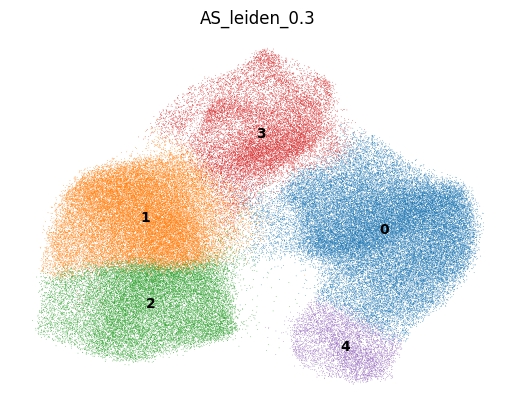

Clustering at resolution 0.5...
Done.


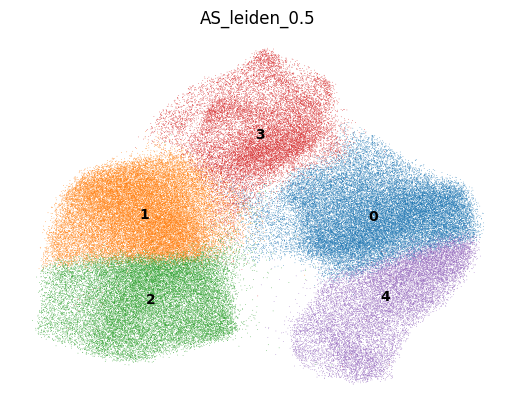

Clustering at resolution 0.8...
Done.


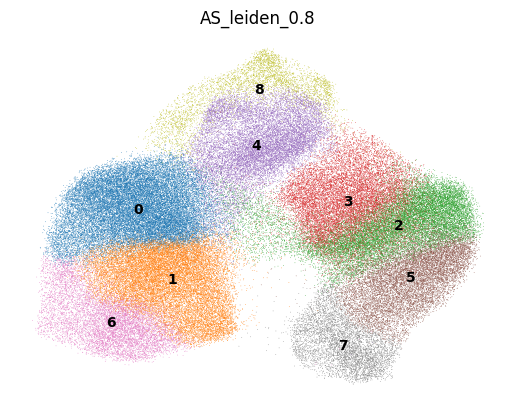

Clustering at resolution 1...
Done.


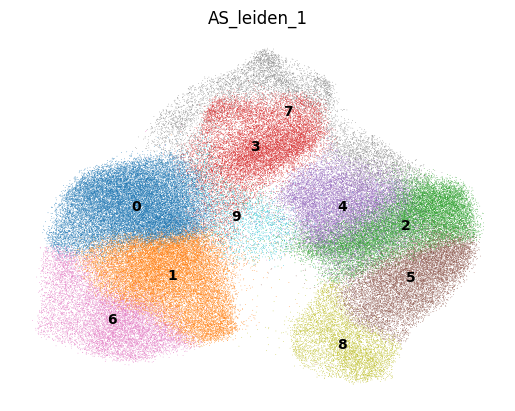

In [28]:
resolutions = [0.3, 0.5,0.8, 1]

for resolution in resolutions:
    key = f'AS_leiden_{resolution}'

    if key in adata_AS.obs.columns:
        print(f"Skipping {resolution}: {key} already exists.")
    else:
        print(f"Clustering at resolution {resolution}...")
        sc.tl.leiden(adata_AS, resolution=resolution, key_added=key)
        print("Done.")

    # plot UMAP
    sc.pl.umap(adata_AS, color=key, legend_loc='on data', frameon=False)

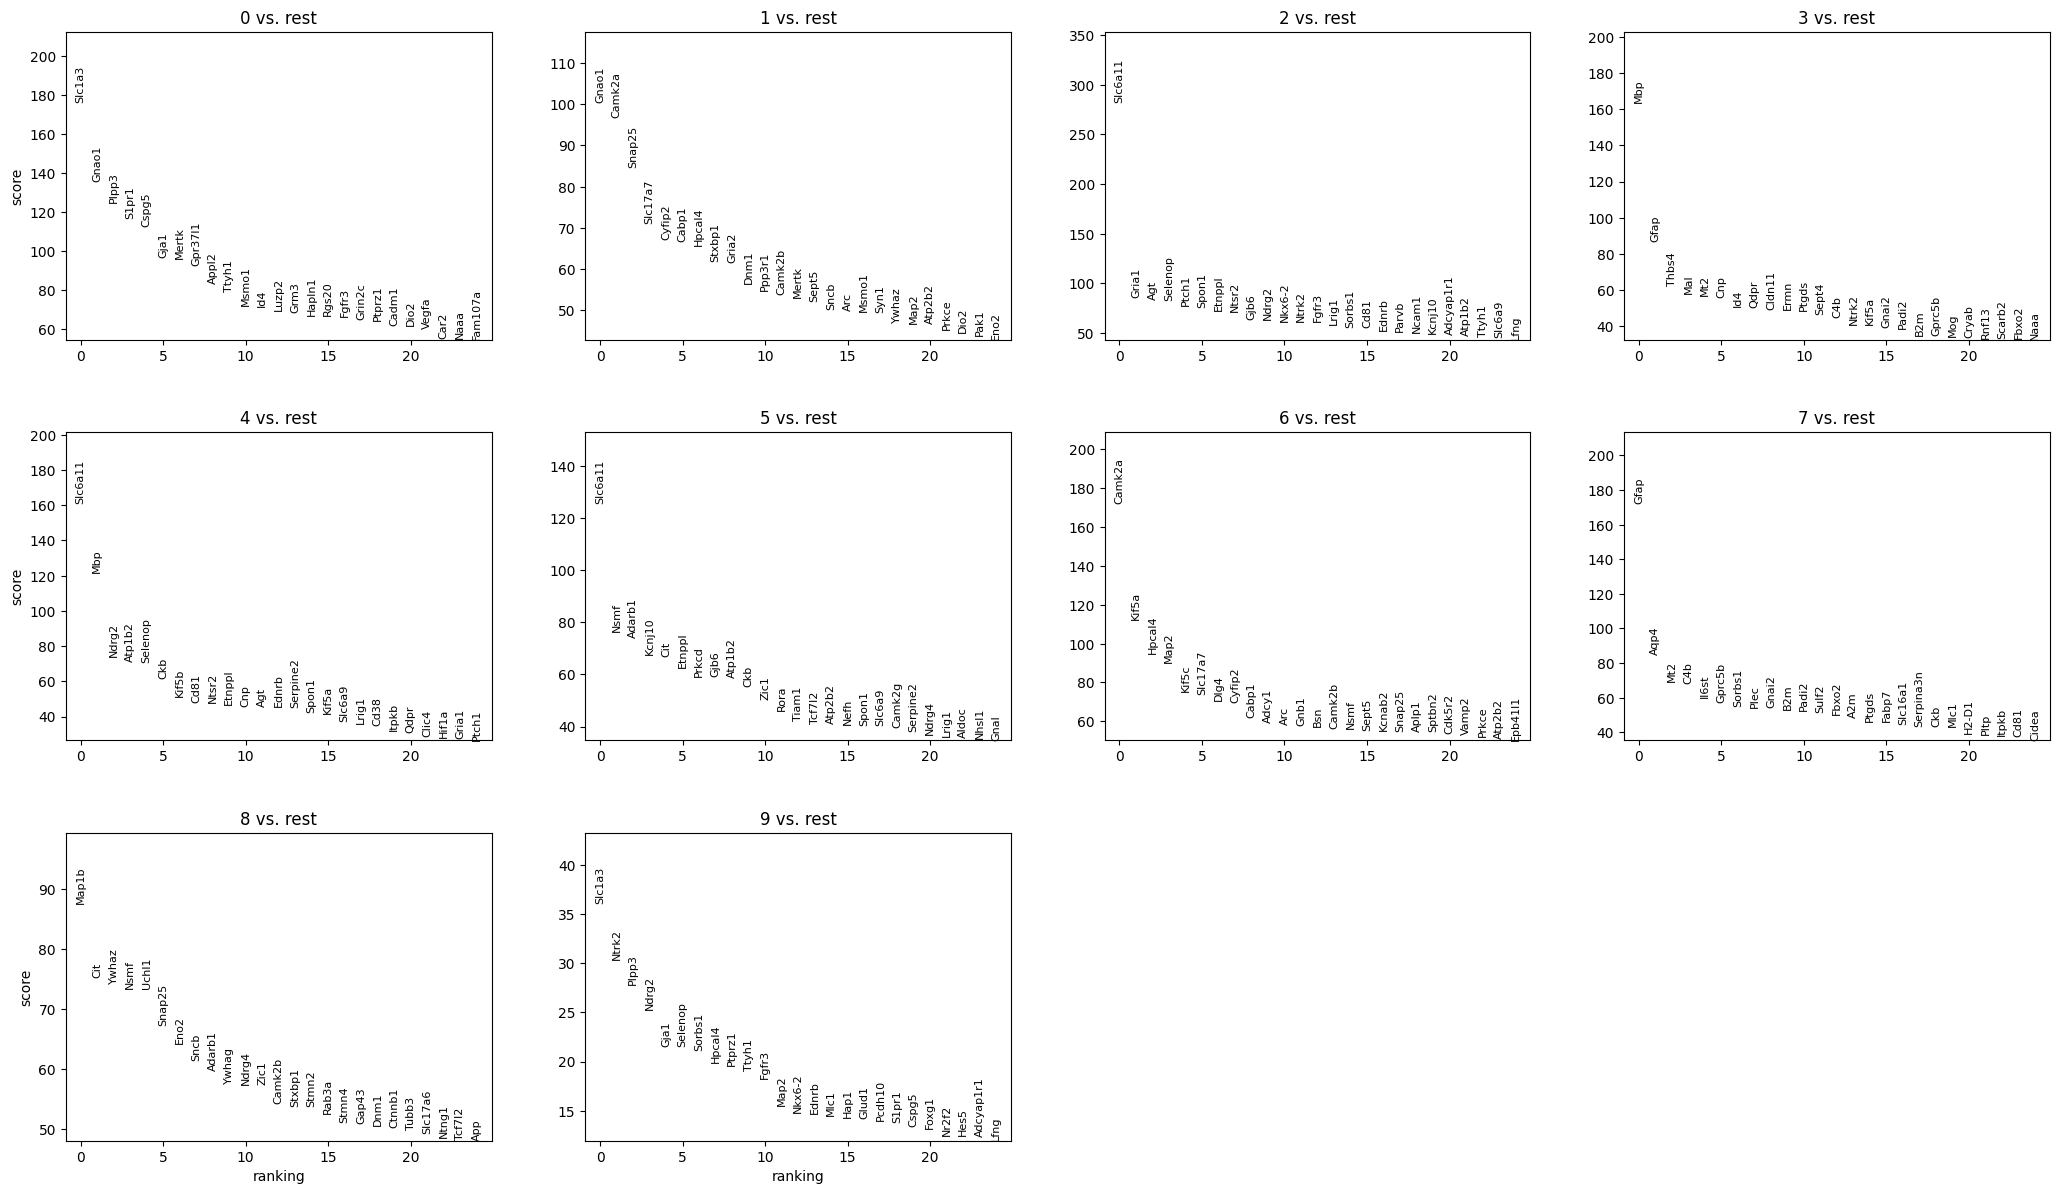

group   names      scores  logfoldchanges  pvals  pvals_adj
0     0  Slc1a3  176.040070        0.980342    0.0        0.0
1     0   Gnao1  135.930511        1.210013    0.0        0.0
2     0   Plpp3  124.980461        0.819599    0.0        0.0
3     0   S1pr1  116.537010        1.027626    0.0        0.0
4     0   Cspg5  112.912140        1.309742    0.0        0.0

In [29]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(adata_AS, groupby="AS_leiden_1", method="t-test")
sc.pl.rank_genes_groups(adata_AS, n_genes=25, sharey=False)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(adata_AS, group=None)
markers.head()

In [30]:
marker_genes = pd.DataFrame({
    group: adata_AS.uns['rank_genes_groups']['names'][group][:20]
    for group in adata_AS.uns['rank_genes_groups']['names'].dtype.names
})


In [31]:
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

0
Slc1a3 Gnao1 Plpp3 S1pr1 Cspg5 Gja1 Mertk Gpr37l1 Appl2 Ttyh1 Msmo1 Id4 Luzp2 Grm3 Hapln1 Rgs20 Fgfr3 Grin2c Ptprz1 Cadm1
 
1
Gnao1 Camk2a Snap25 Slc17a7 Cyfip2 Cabp1 Hpcal4 Stxbp1 Gria2 Dnm1 Ppp3r1 Camk2b Mertk Sept5 Sncb Arc Msmo1 Syn1 Ywhaz Map2
 
2
Slc6a11 Gria1 Agt Selenop Ptch1 Spon1 Etnppl Ntsr2 Gjb6 Ndrg2 Nkx6-2 Ntrk2 Fgfr3 Lrig1 Sorbs1 Cd81 Ednrb Parvb Ncam1 Kcnj10
 
3
Mbp Gfap Thbs4 Mal Mt2 Cnp Id4 Qdpr Cldn11 Ermn Ptgds Sept4 C4b Ntrk2 Kif5a Gnai2 Padi2 B2m Gprc5b Mog
 
4
Slc6a11 Mbp Ndrg2 Atp1b2 Selenop Ckb Kif5b Cd81 Ntsr2 Etnppl Cnp Agt Ednrb Serpine2 Spon1 Kif5a Slc6a9 Lrig1 Cd38 Itpkb
 
5
Slc6a11 Nsmf Adarb1 Kcnj10 Cit Etnppl Prkcd Gjb6 Atp1b2 Ckb Zic1 Rora Tiam1 Tcf7l2 Atp2b2 Nefh Spon1 Slc6a9 Camk2g Serpine2
 
6
Camk2a Kif5a Hpcal4 Map2 Kif5c Slc17a7 Dlg4 Cyfip2 Cabp1 Adcy1 Arc Gnb1 Bsn Camk2b Nsmf Sept5 Kcnab2 Snap25 Aplp1 Sptbn2
 
7
Gfap Aqp4 Mt2 C4b Il6st Gprc5b Sorbs1 Plec Gnai2 B2m Padi2 Sulf2 Fbxo2 A2m Ptgds Fabp7 Slc16a1 Serpina3n Ckb Mlc1
 
8
Map1b Cit Ywhaz

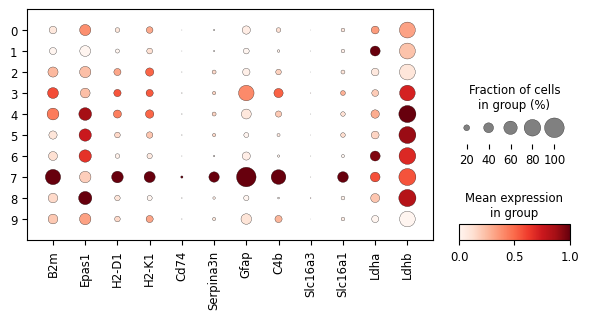

In [38]:
 sc.pl.dotplot(
        adata_AS,
        var_names=['B2m', 'Epas1', 'H2-D1', 'H2-K1', 'Cd74','Serpina3n','Gfap','C4b','Slc16a3','Slc16a1','Ldha','Ldhb'],
        groupby="AS_leiden_1",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=False,
        figsize=(7, 3),
        
    )

<Figure size 800x500 with 0 Axes>

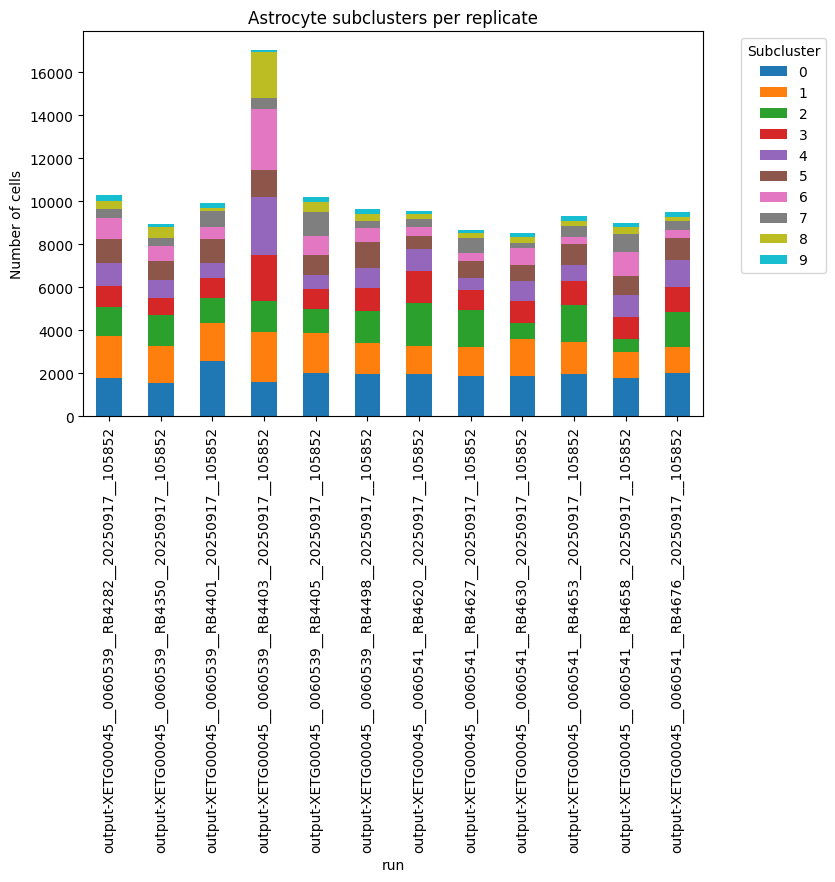

<Figure size 800x500 with 0 Axes>

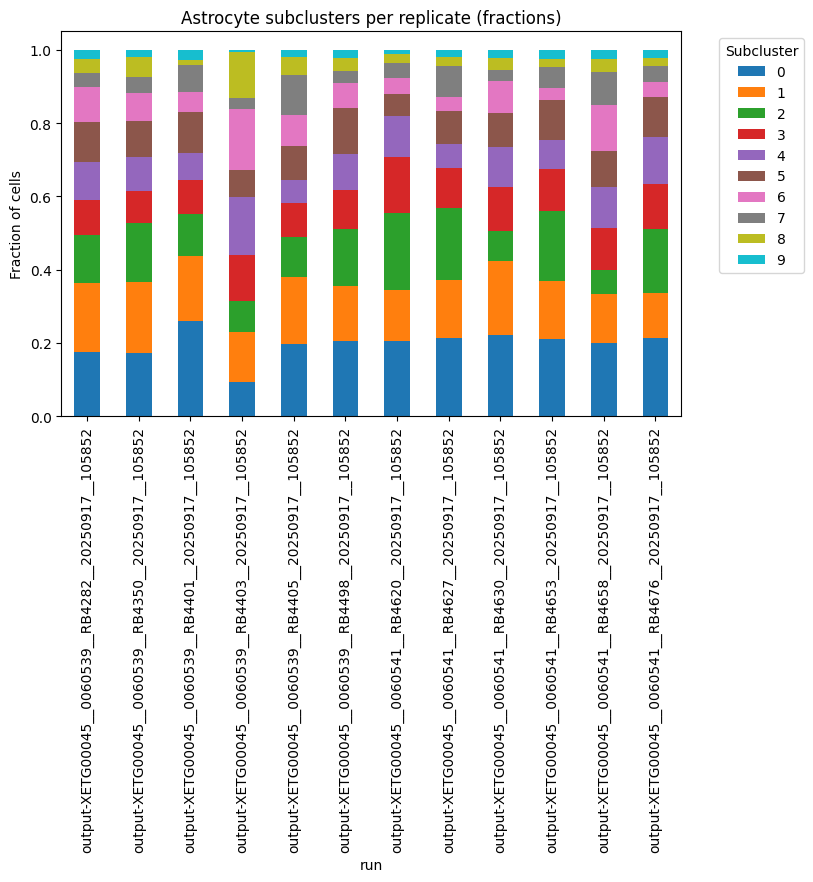

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# pick your cluster key (change if needed)
cluster_key = "AS_leiden_1"  

# count cells per replicate × cluster
ct = pd.crosstab(adata_AS.obs[cluster_key], adata_AS.obs["run"])

# plot counts
plt.figure(figsize=(8,5))
ct.T.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Number of cells")
plt.title("Astrocyte subclusters per replicate")
plt.legend(title="Subcluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# plot fractions
fractions = ct.div(ct.sum(axis=0), axis=1)

plt.figure(figsize=(8,5))
fractions.T.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Fraction of cells")
plt.title("Astrocyte subclusters per replicate (fractions)")
plt.legend(title="Subcluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

output-XETG00045__0060539__RB4282__20250917__105852


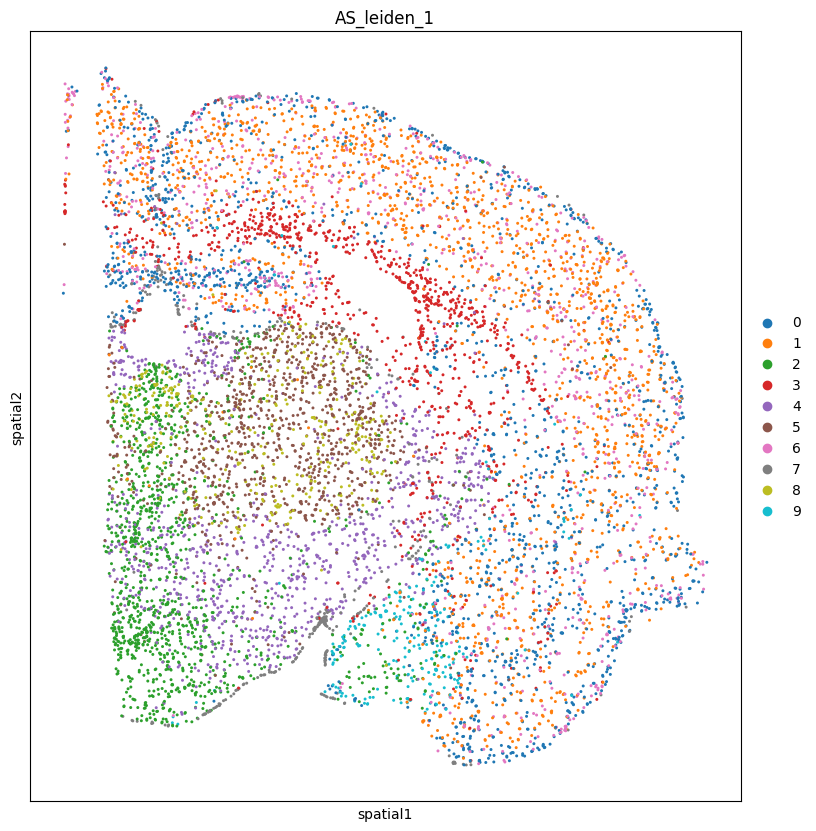

output-XETG00045__0060539__RB4350__20250917__105852


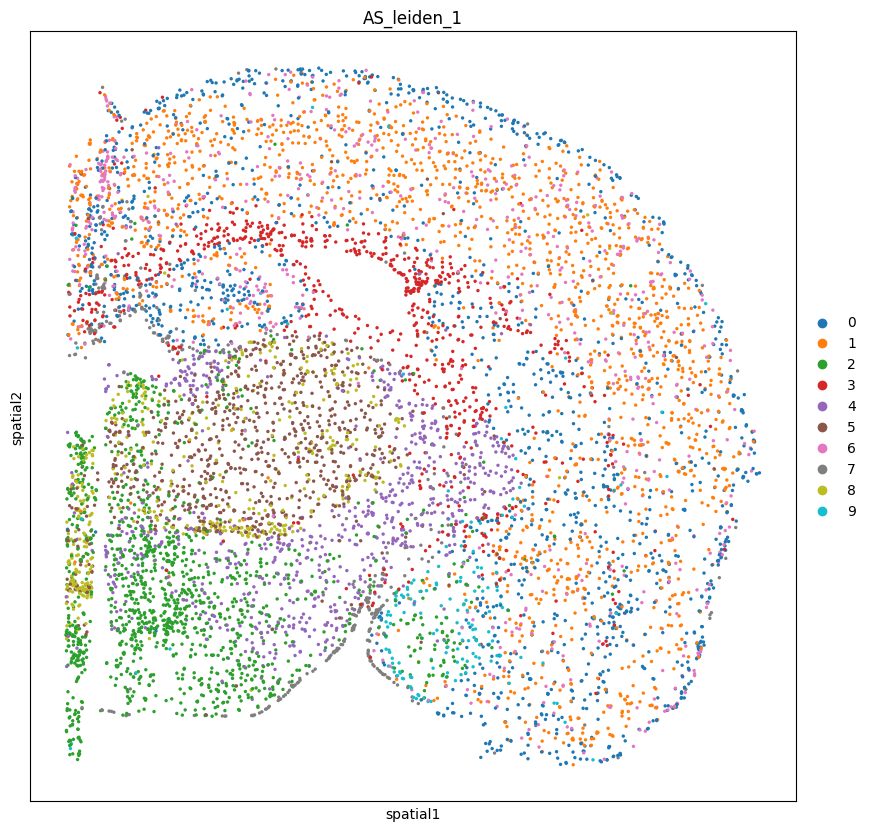

output-XETG00045__0060539__RB4401__20250917__105852


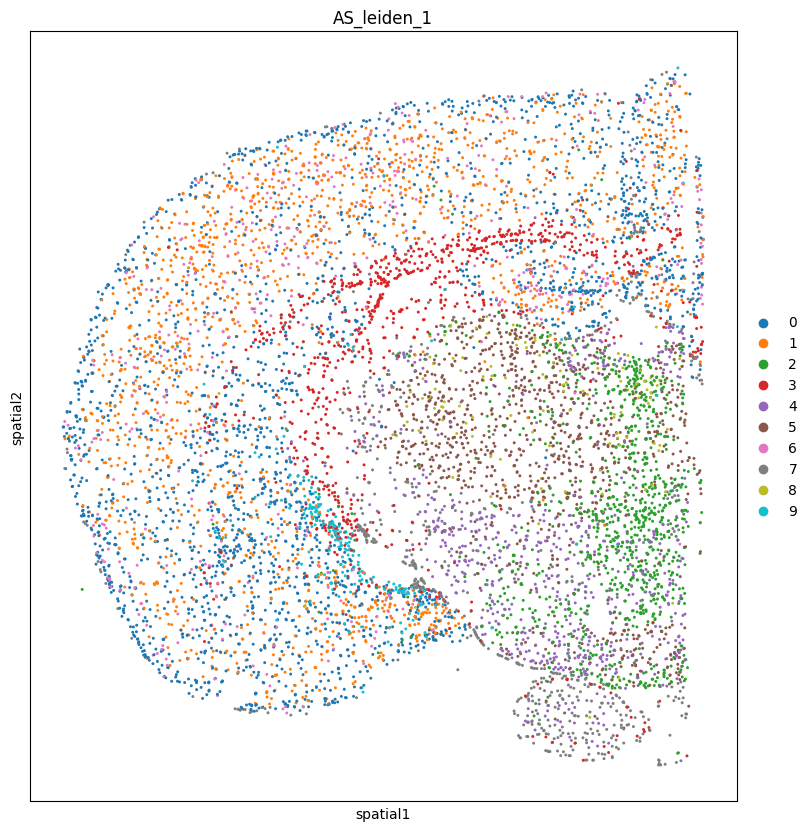

output-XETG00045__0060539__RB4403__20250917__105852


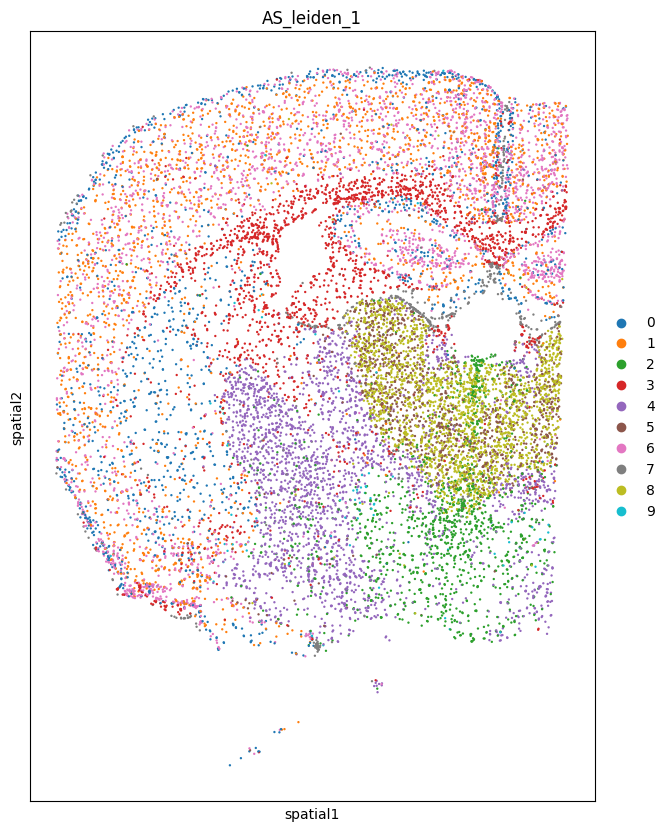

output-XETG00045__0060539__RB4405__20250917__105852


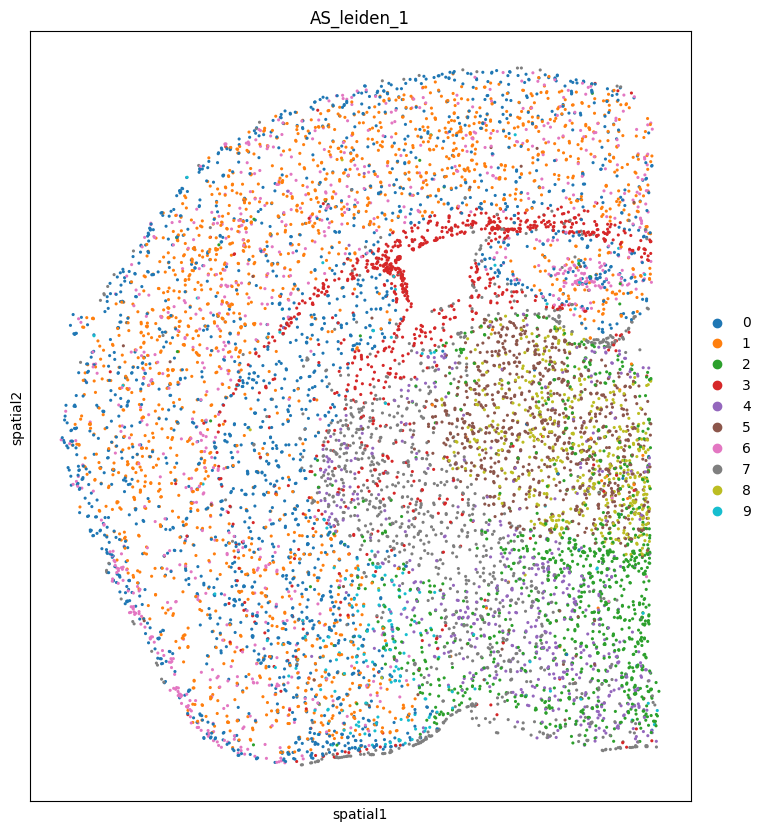

output-XETG00045__0060539__RB4498__20250917__105852


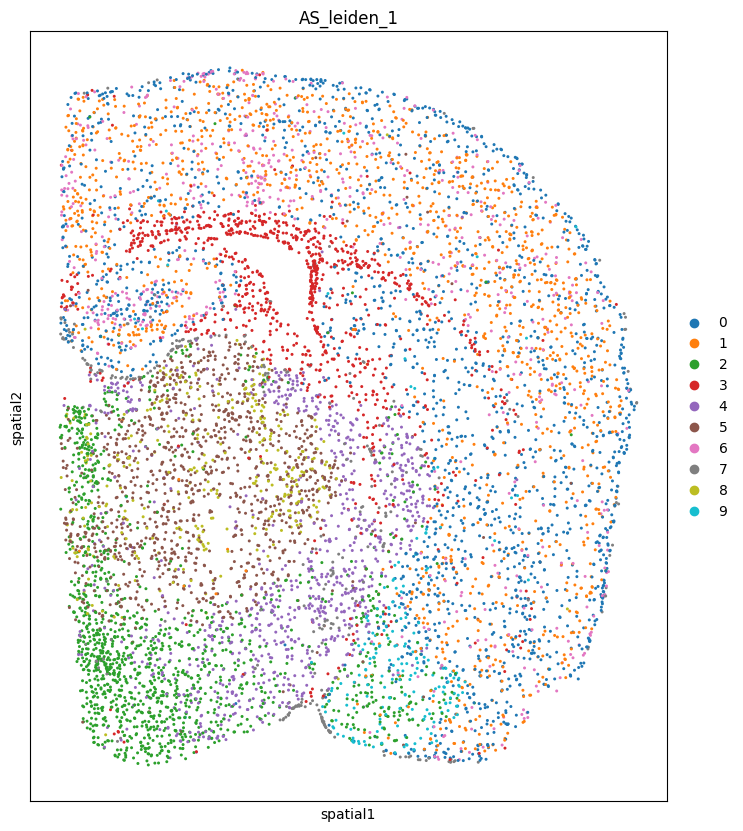

output-XETG00045__0060541__RB4620__20250917__105852


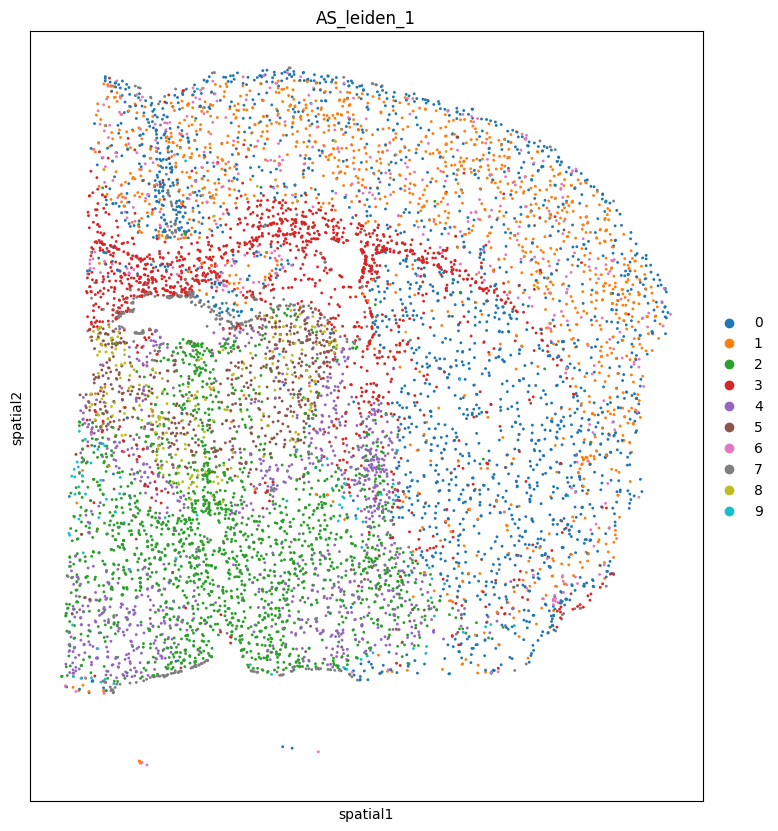

output-XETG00045__0060541__RB4627__20250917__105852


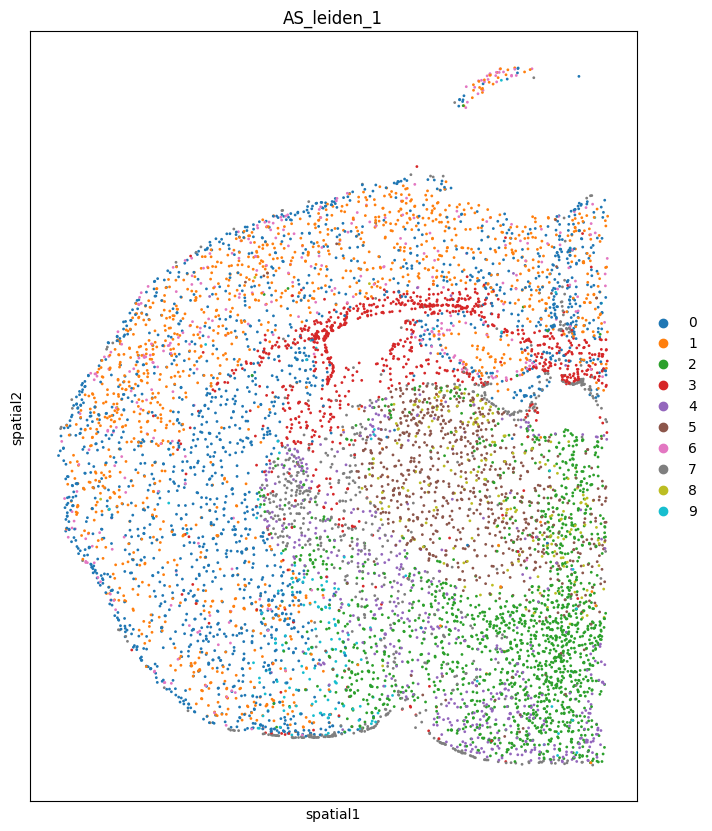

output-XETG00045__0060541__RB4630__20250917__105852


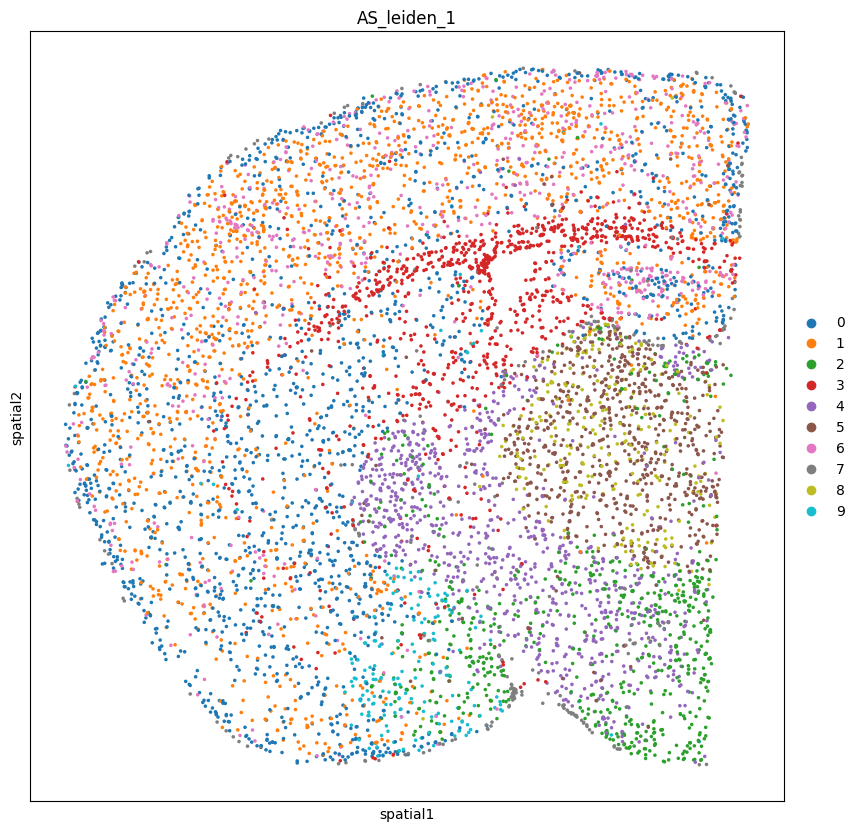

output-XETG00045__0060541__RB4653__20250917__105852


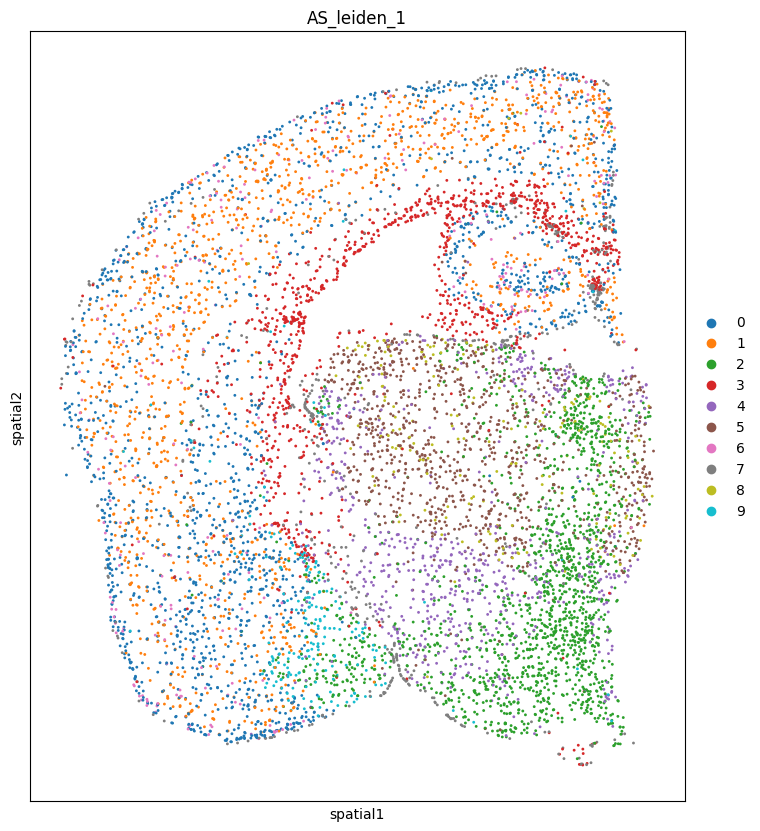

output-XETG00045__0060541__RB4658__20250917__105852


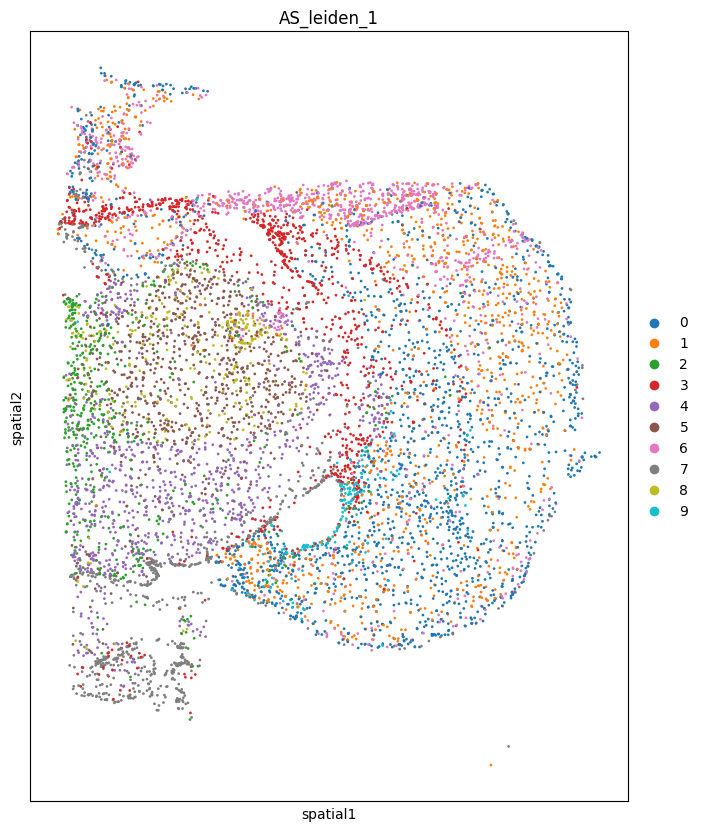

output-XETG00045__0060541__RB4676__20250917__105852


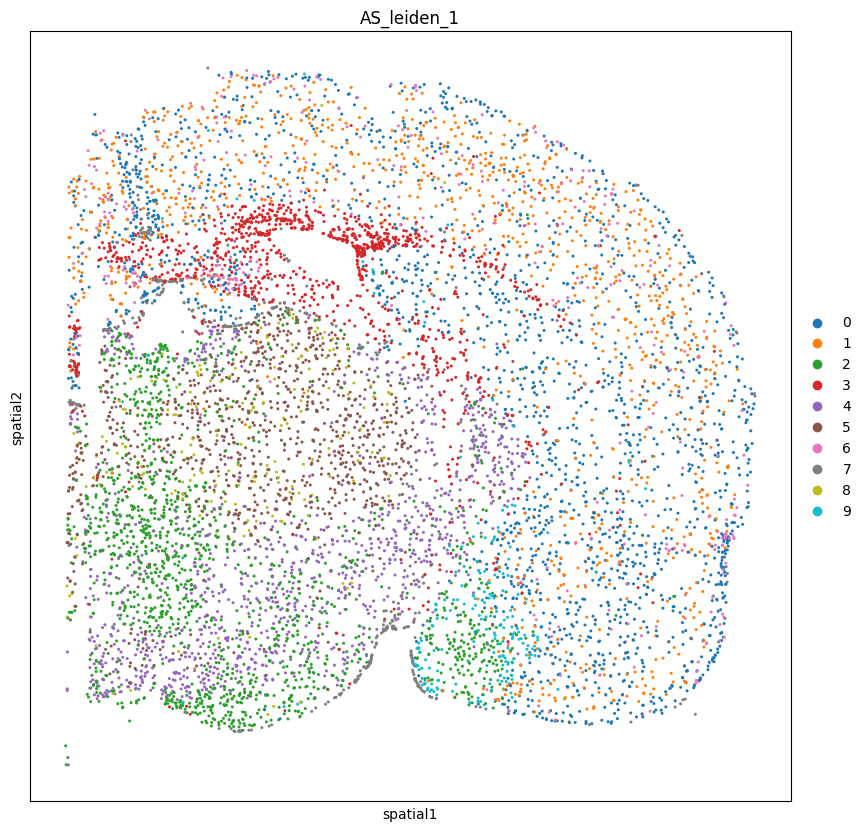

In [42]:
for run in adata_AS.obs['run'].unique():
    print(run)
    ad_int = adata_AS[adata_AS.obs['run'] == run]
    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=25, color = 'AS_leiden_1')
    plt.show()
    